Importing libraries and data

In [4]:
pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [5]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings 

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [8]:
# Configure API key 

quandl.ApiConfig.api_key = 'FiqzBX8s2V3jSsY6TDg2'

In [6]:
#Importing dataframe
df = pd.read_csv(r'/Users/Nimrat/Documents/World Happiness Report/Original data/unemployment_rate.csv')

In [7]:
#Checking the data
df.head()

,observation_date,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [9]:
#Renaming column name
df = df.rename(columns={'observation_date': 'date', 'UNRATE': 'unemployment_rate'})

In [10]:
df.shape

(935, 2)

In [11]:
type(df)

pandas.core.frame.DataFrame

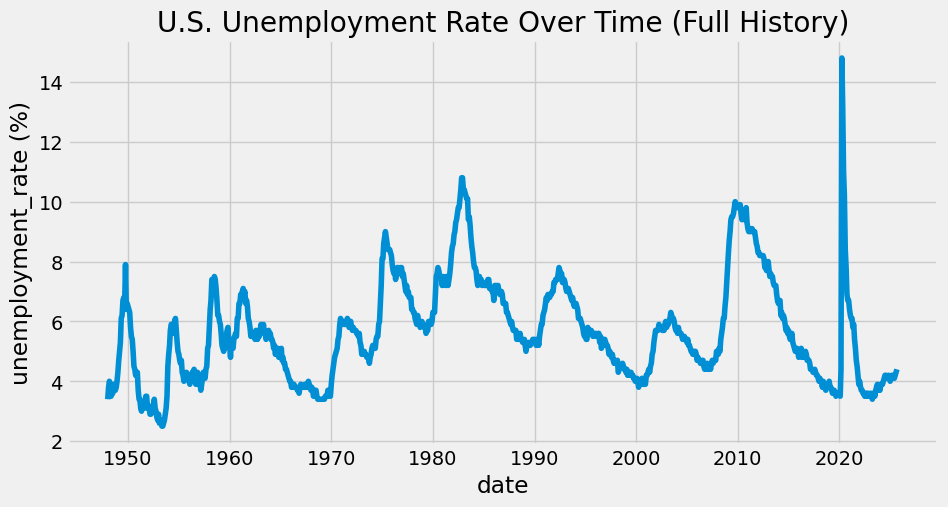

In [17]:
# Plot the data using matplotlib.

# Ensure date is datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values('date')

plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['unemployment_rate'])
plt.title('U.S. Unemployment Rate Over Time (Full History)')
plt.xlabel('date')
plt.ylabel('unemployment_rate (%)')
plt.show()

Subsetting the data

In [18]:
# Reset index to use the "Date" column as a filter

df_2 = df.reset_index()

In [19]:
df_2.head()

,index,date,unemployment_rate
0,0,1948-01-01,3.4
1,1,1948-02-01,3.8
2,2,1948-03-01,4.0
3,3,1948-04-01,3.9
4,4,1948-05-01,3.5


In [21]:
#Subset time range
df_sub = df_2.loc[(df_2['date'] >= '1980-01-01') & (df_2['date'] < '2020-12-01')]

In [22]:
df_sub.shape

(491, 3)

In [23]:
df_sub.head()

,index,date,unemployment_rate
384,384,1980-01-01,6.3
385,385,1980-02-01,6.3
386,386,1980-03-01,6.3
387,387,1980-04-01,6.9
388,388,1980-05-01,7.5


In [24]:
# Set the "Date" column as the index

from datetime import datetime

df_sub['datetime'] = pd.to_datetime(df_sub['date']) # Create a datetime column from "Date.""
df_sub = df_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
df_sub.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
df_sub.head()

,index,unemployment_rate
datetime,,
1980-01-01,384,6.3
1980-02-01,385,6.3
1980-03-01,386,6.3
1980-04-01,387,6.9
1980-05-01,388,7.5


Create a line chart

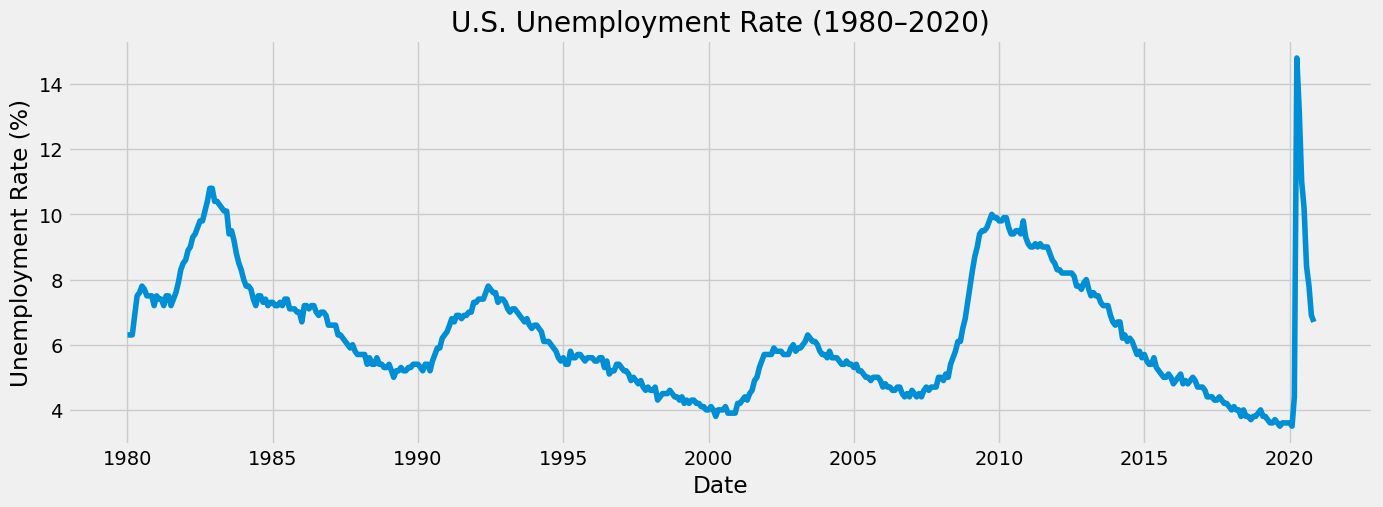

In [27]:
# Create a line chart

plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_sub.index, df_sub['unemployment_rate'])
plt.title('U.S. Unemployment Rate (1980–2020)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.show()

In [28]:
#Check for missing values
df_sub.isnull().sum()

index                0
unemployment_rate    0
dtype: int64

In [29]:
#Check for duplicates
dups = df_sub.duplicated()
dups.sum()

np.int64(0)

Decompost the data's components

In [30]:
# Use the unemployment rate series
series = df_sub['unemployment_rate']

In [35]:
# Decompose the time series using an additive model

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series, model='additive', period=12)

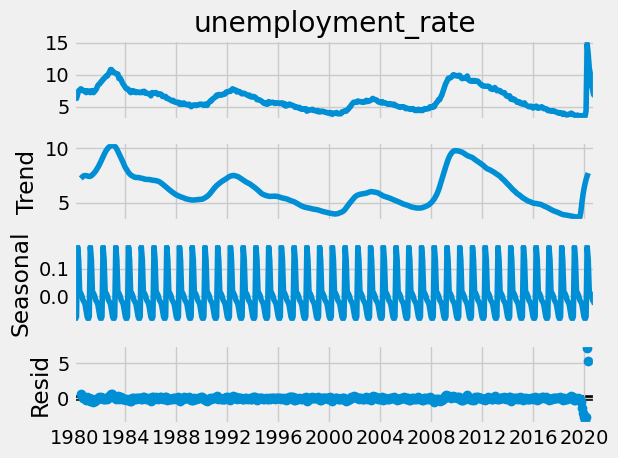

In [36]:
#Plot the components
decomposition.plot()
plt.show()

The decomposition shows that unemployment changes over time mainly due to long-term economic trends. The trend line highlights major events such as recessions and economic slowdowns, where unemployment rises and then gradually falls. The seasonal pattern shows small, regular monthly changes that repeat each year, but these are much weaker than the overall trend. The residuals capture unexpected events, such as sudden economic shocks, and are mostly centered around zero, which means the model fits the data well.

Conduct a Dickey-Fuller Test

In [41]:
#Import the adfuller() function
from statsmodels.tsa.stattools import adfuller

#Define the function
def dickey_fuller(timeseries):

# Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        result['Critical Value (%s)'%key] = value
    print (result)

In [42]:
#Apply the test using the function on the time series
dickey_fuller(df_sub['unemployment_rate'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.993295
p-value                          0.035525
Number of Lags Used             10.000000
Number of Observations Used    480.000000
Critical Value (1%)             -3.444047
Critical Value (5%)             -2.867580
Critical Value (10%)            -2.569987
dtype: float64


Dickey-Fuller (ADF) test was conducted to check whether the unemployment rate time series is stationary.
- Null hypothesis (H₀): The time series is not stationary.
- Alternative hypothesis (H₁): The time series is stationary.
The test produced a p-value of 0.0355, which is less than 0.05. Therefore, we reject the null hypothesis. This indicates that the unemployment rate time series is stationary at the 5% significance level.

If data isn’t stationary, conduct a round of differencing on it.

In [43]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
df_diff = df_sub - df_sub.shift(1)

In [44]:
#Drop missing value created by differencing
df_diff = df_diff.dropna()

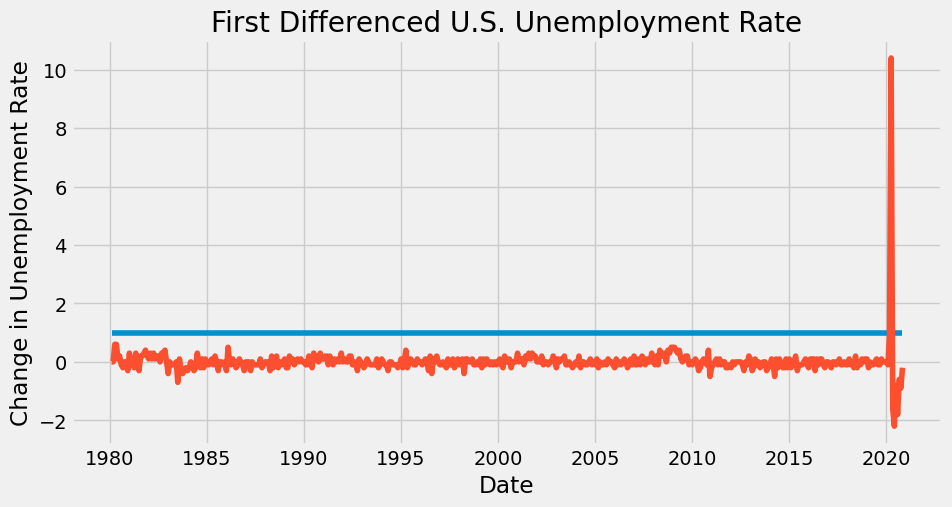

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(df_diff)
plt.title('First Differenced U.S. Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Change in Unemployment Rate')
plt.show()

In [49]:
#Repeat the Dickey-Fuller Test
dickey_fuller(df_diff['unemployment_rate'])

Dickey-Fuller Stationarity test:
Test Statistic                  -5.204940
p-value                          0.000009
Number of Lags Used              8.000000
Number of Observations Used    481.000000
Critical Value (1%)             -3.444018
Critical Value (5%)             -2.867568
Critical Value (10%)            -2.569980
dtype: float64


After applying first differencing, the Dickey-Fuller test confirms that the differenced unemployment rate series is stationary, as the p-value is below 0.05. This indicates that differencing successfully removed any remaining non-stationary behavior.

Data's autocorrelations

In [56]:
#Check differenced series has real data
df_diff = df_sub['unemployment_rate'].diff().dropna()

print("Length:", len(df_diff))
print("Min:", df_diff.min())
print("Max:", df_diff.max())
print("Std:", df_diff.std())
df_diff.head()

Length: 490
Min: -2.1999999999999993
Max: 10.4
Std: 0.5254264476405223


datetime
1980-02-01    0.0
1980-03-01    0.0
1980-04-01    0.6
1980-05-01    0.6
1980-06-01    0.1
Name: unemployment_rate, dtype: float64

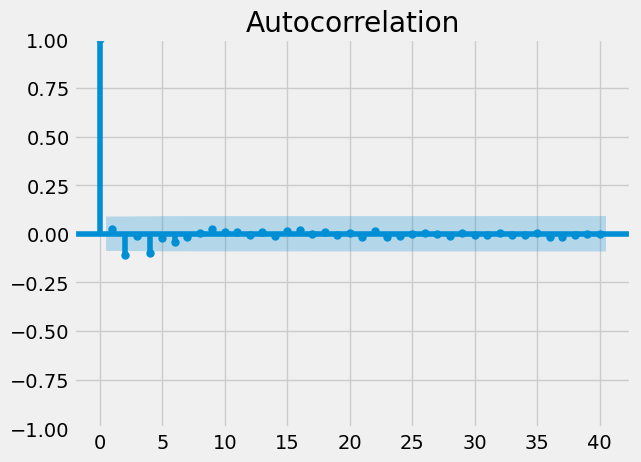

In [59]:
#Plot the autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# df_diff is already correct from your check
df_diff = df_sub['unemployment_rate'].diff().dropna()

# Plot ACF (no plt.figure before it)
fig = plot_acf(df_diff, lags=40)
plt.title('Autocorrelation')
plt.show()

Most bars are close to zero and stay within the confidence band, which suggests weak autocorrelation after differencing. This supports that the series is behaving more like a stationary time series.